## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization,Activation

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], pre = True):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units,name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units,name="hidden_layer"+str(i+1))(x)
            
        if pre:
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        else:
            x = Activation('relu')(x) 
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZES = [2, 16, 32, 128, 256]
MOMENTUM = 0.95
PRE = [True, False]

In [7]:
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
results = {}

for (pre ,batch_size) in itertools.product(PRE, BATCH_SIZES):
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("pre: %s, batch_size: %i" % (pre, batch_size) )
    model = build_mlp(input_shape=x_train.shape[1:], pre=pre)
    model.summary()
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=batch_size, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = "exp-pre-%s-bz-%s" % (pre, batch_size)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

W0723 11:25:51.455400  7268 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0723 11:25:51.456400  7268 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 11:25:51.665400  7268 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 11:25:51.666400  7268 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 11:25:51.669400  7268 deprecation_wrapper.py:119] From D:\Anaconda3\li

pre: True, batch_size: 2


W0723 11:25:52.002400  7268 deprecation_wrapper.py:119] From D:\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 11:25:52.090400  7268 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
__________

50000/50000 [==============================] - 315s 6ms/step - loss: 2.2727 - acc: 0.1351 - val_loss: 2.3029 - val_acc: 0.1236
Epoch 47/50
50000/50000 [==============================] - 313s 6ms/step - loss: 2.2740 - acc: 0.1337 - val_loss: 2.3052 - val_acc: 0.1058
Epoch 48/50
50000/50000 [==============================] - 326s 7ms/step - loss: 2.2738 - acc: 0.1324 - val_loss: 2.2967 - val_acc: 0.1151
Epoch 49/50
50000/50000 [==============================] - 318s 6ms/step - loss: 2.2710 - acc: 0.1312 - val_loss: 2.2881 - val_acc: 0.1243
Epoch 50/50
50000/50000 [==============================] - 313s 6ms/step - loss: 2.2715 - acc: 0.1370 - val_loss: 2.3010 - val_acc: 0.1199
pre: True, batch_size: 16
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)      

50000/50000 [==============================] - 41s 820us/step - loss: 0.5590 - acc: 0.8025 - val_loss: 1.7772 - val_acc: 0.5139
Epoch 42/50
50000/50000 [==============================] - 40s 808us/step - loss: 0.5532 - acc: 0.8021 - val_loss: 1.8120 - val_acc: 0.5058
Epoch 43/50
50000/50000 [==============================] - 42s 841us/step - loss: 0.5428 - acc: 0.8108 - val_loss: 1.7574 - val_acc: 0.5272
Epoch 44/50
50000/50000 [==============================] - 44s 885us/step - loss: 0.5327 - acc: 0.8137 - val_loss: 1.7870 - val_acc: 0.5167
Epoch 45/50
50000/50000 [==============================] - 41s 817us/step - loss: 0.5194 - acc: 0.8187 - val_loss: 1.7581 - val_acc: 0.5232
Epoch 46/50
50000/50000 [==============================] - 41s 824us/step - loss: 0.5215 - acc: 0.8168 - val_loss: 1.7271 - val_acc: 0.5298
Epoch 47/50
50000/50000 [==============================] - 40s 803us/step - loss: 0.5060 - acc: 0.8211 - val_loss: 1.7827 - val_acc: 0.5224
Epoch 48/50
50000/50000 [=======

50000/50000 [==============================] - 20s 392us/step - loss: 0.3290 - acc: 0.8843 - val_loss: 2.3179 - val_acc: 0.4916
Epoch 37/50
50000/50000 [==============================] - 20s 391us/step - loss: 0.3189 - acc: 0.8880 - val_loss: 2.2098 - val_acc: 0.4836
Epoch 38/50
50000/50000 [==============================] - 20s 391us/step - loss: 0.3079 - acc: 0.8913 - val_loss: 2.3314 - val_acc: 0.4946
Epoch 39/50
50000/50000 [==============================] - 20s 392us/step - loss: 0.3080 - acc: 0.8917 - val_loss: 2.2266 - val_acc: 0.4875
Epoch 40/50
50000/50000 [==============================] - 20s 391us/step - loss: 0.2989 - acc: 0.8958 - val_loss: 2.1886 - val_acc: 0.5048
Epoch 41/50
50000/50000 [==============================] - 20s 393us/step - loss: 0.2840 - acc: 0.9002 - val_loss: 2.1660 - val_acc: 0.5096
Epoch 42/50
50000/50000 [==============================] - 20s 393us/step - loss: 0.2787 - acc: 0.9012 - val_loss: 2.4328 - val_acc: 0.4907
Epoch 43/50
50000/50000 [=======

50000/50000 [==============================] - 6s 126us/step - loss: 0.1450 - acc: 0.9590 - val_loss: 2.4319 - val_acc: 0.4718
Epoch 32/50
50000/50000 [==============================] - 6s 125us/step - loss: 0.1351 - acc: 0.9620 - val_loss: 2.5396 - val_acc: 0.4750
Epoch 33/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.1280 - acc: 0.9638 - val_loss: 2.5727 - val_acc: 0.4616
Epoch 34/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.1210 - acc: 0.9653 - val_loss: 2.6197 - val_acc: 0.4690
Epoch 35/50
50000/50000 [==============================] - 6s 128us/step - loss: 0.1129 - acc: 0.9681 - val_loss: 2.7109 - val_acc: 0.4704
Epoch 36/50
50000/50000 [==============================] - 6s 127us/step - loss: 0.1046 - acc: 0.9710 - val_loss: 2.6239 - val_acc: 0.4629
Epoch 37/50
50000/50000 [==============================] - 6s 126us/step - loss: 0.0996 - acc: 0.9721 - val_loss: 2.9371 - val_acc: 0.4406
Epoch 38/50
50000/50000 [==============

Epoch 27/50
50000/50000 [==============================] - 4s 81us/step - loss: 0.2640 - acc: 0.9344 - val_loss: 1.9980 - val_acc: 0.4725
Epoch 28/50
50000/50000 [==============================] - 4s 81us/step - loss: 0.2379 - acc: 0.9415 - val_loss: 2.1708 - val_acc: 0.4515
Epoch 29/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.2151 - acc: 0.9500 - val_loss: 2.2346 - val_acc: 0.4722
Epoch 30/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.1903 - acc: 0.9593 - val_loss: 2.1456 - val_acc: 0.4685
Epoch 31/50
50000/50000 [==============================] - 4s 79us/step - loss: 0.1787 - acc: 0.9617 - val_loss: 2.1834 - val_acc: 0.4657
Epoch 32/50
50000/50000 [==============================] - 4s 81us/step - loss: 0.1560 - acc: 0.9687 - val_loss: 2.1768 - val_acc: 0.4724
Epoch 33/50
50000/50000 [==============================] - 4s 80us/step - loss: 0.1476 - acc: 0.9709 - val_loss: 2.2031 - val_acc: 0.4796
Epoch 34/50
50000/50000 [=========

50000/50000 [==============================] - 302s 6ms/step - loss: 2.2781 - acc: 0.1394 - val_loss: 2.9935 - val_acc: 0.1818
Epoch 23/50
50000/50000 [==============================] - 307s 6ms/step - loss: 2.2803 - acc: 0.1392 - val_loss: 2.5611 - val_acc: 0.1656
Epoch 24/50
50000/50000 [==============================] - 309s 6ms/step - loss: 2.2741 - acc: 0.1396 - val_loss: 2.4842 - val_acc: 0.1673
Epoch 25/50
50000/50000 [==============================] - 324s 6ms/step - loss: 2.2712 - acc: 0.1435 - val_loss: 2.4168 - val_acc: 0.1696
Epoch 26/50
50000/50000 [==============================] - 319s 6ms/step - loss: 2.2634 - acc: 0.1505 - val_loss: 2.2890 - val_acc: 0.1697
Epoch 27/50
50000/50000 [==============================] - 319s 6ms/step - loss: 2.2604 - acc: 0.1500 - val_loss: 2.3592 - val_acc: 0.1622
Epoch 28/50
50000/50000 [==============================] - 300s 6ms/step - loss: 2.2693 - acc: 0.1425 - val_loss: 2.6334 - val_acc: 0.1597
Epoch 29/50
50000/50000 [==============

50000/50000 [==============================] - 45s 906us/step - loss: 1.3142 - acc: 0.5326 - val_loss: 1.3346 - val_acc: 0.5318
Epoch 18/50
50000/50000 [==============================] - 42s 842us/step - loss: 1.3039 - acc: 0.5378 - val_loss: 1.3865 - val_acc: 0.5138
Epoch 19/50
50000/50000 [==============================] - 42s 844us/step - loss: 1.2905 - acc: 0.5417 - val_loss: 1.3545 - val_acc: 0.5199
Epoch 20/50
50000/50000 [==============================] - 43s 863us/step - loss: 1.2753 - acc: 0.5476 - val_loss: 1.3948 - val_acc: 0.5058
Epoch 21/50
50000/50000 [==============================] - 41s 828us/step - loss: 1.2690 - acc: 0.5502 - val_loss: 1.3949 - val_acc: 0.5091
Epoch 22/50
50000/50000 [==============================] - 41s 828us/step - loss: 1.2720 - acc: 0.5492 - val_loss: 1.3756 - val_acc: 0.5117
Epoch 23/50
50000/50000 [==============================] - 41s 825us/step - loss: 1.2572 - acc: 0.5551 - val_loss: 1.3678 - val_acc: 0.5134
Epoch 24/50
50000/50000 [=======

50000/50000 [==============================] - 21s 425us/step - loss: 1.2189 - acc: 0.5655 - val_loss: 1.6171 - val_acc: 0.4461
Epoch 13/50
50000/50000 [==============================] - 21s 424us/step - loss: 1.1943 - acc: 0.5756 - val_loss: 1.5475 - val_acc: 0.4677
Epoch 14/50
50000/50000 [==============================] - 21s 419us/step - loss: 1.1686 - acc: 0.5863 - val_loss: 1.4205 - val_acc: 0.5116
Epoch 15/50
50000/50000 [==============================] - 20s 409us/step - loss: 1.1571 - acc: 0.5903 - val_loss: 1.4263 - val_acc: 0.5066
Epoch 16/50
50000/50000 [==============================] - 21s 417us/step - loss: 1.1219 - acc: 0.6005 - val_loss: 1.3550 - val_acc: 0.5252
Epoch 17/50
50000/50000 [==============================] - 21s 414us/step - loss: 1.1053 - acc: 0.6074 - val_loss: 1.4018 - val_acc: 0.5104
Epoch 18/50
50000/50000 [==============================] - 21s 421us/step - loss: 1.0935 - acc: 0.6092 - val_loss: 1.4357 - val_acc: 0.5042
Epoch 19/50
50000/50000 [=======

50000/50000 [==============================] - 7s 130us/step - loss: 1.1709 - acc: 0.5905 - val_loss: 1.5129 - val_acc: 0.4654
Epoch 8/50
50000/50000 [==============================] - 6s 126us/step - loss: 1.1324 - acc: 0.6033 - val_loss: 1.5025 - val_acc: 0.4824
Epoch 9/50
50000/50000 [==============================] - 6s 125us/step - loss: 1.0985 - acc: 0.6149 - val_loss: 1.4869 - val_acc: 0.4771
Epoch 10/50
50000/50000 [==============================] - 8s 155us/step - loss: 1.0601 - acc: 0.6281 - val_loss: 1.4813 - val_acc: 0.4906
Epoch 11/50
50000/50000 [==============================] - 7s 131us/step - loss: 1.0221 - acc: 0.6449 - val_loss: 1.5269 - val_acc: 0.4708
Epoch 12/50
50000/50000 [==============================] - 7s 130us/step - loss: 0.9868 - acc: 0.6563 - val_loss: 1.5084 - val_acc: 0.4908
Epoch 13/50
50000/50000 [==============================] - 6s 129us/step - loss: 0.9515 - acc: 0.6685 - val_loss: 1.4822 - val_acc: 0.4977
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 4s 79us/step - loss: 1.5569 - acc: 0.4543 - val_loss: 1.6471 - val_acc: 0.4170
Epoch 3/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.4470 - acc: 0.4929 - val_loss: 1.6124 - val_acc: 0.4269
Epoch 4/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.3789 - acc: 0.5164 - val_loss: 1.5523 - val_acc: 0.4570
Epoch 5/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.3222 - acc: 0.5362 - val_loss: 1.5796 - val_acc: 0.4410
Epoch 6/50
50000/50000 [==============================] - 4s 80us/step - loss: 1.2691 - acc: 0.5578 - val_loss: 1.4832 - val_acc: 0.4768
Epoch 7/50
50000/50000 [==============================] - 4s 79us/step - loss: 1.2219 - acc: 0.5719 - val_loss: 1.4598 - val_acc: 0.4857
Epoch 8/50
50000/50000 [==============================] - 4s 81us/step - loss: 1.1798 - acc: 0.5890 - val_loss: 1.5525 - val_acc: 0.4604
Epoch 9/50
50000/50000 [============================

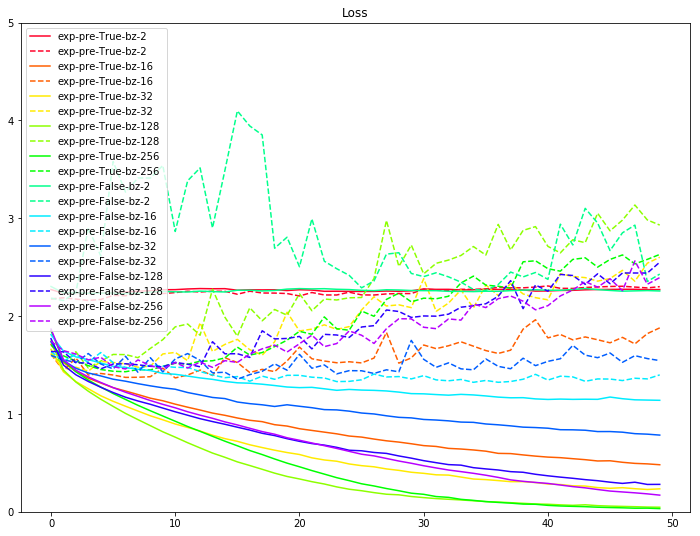

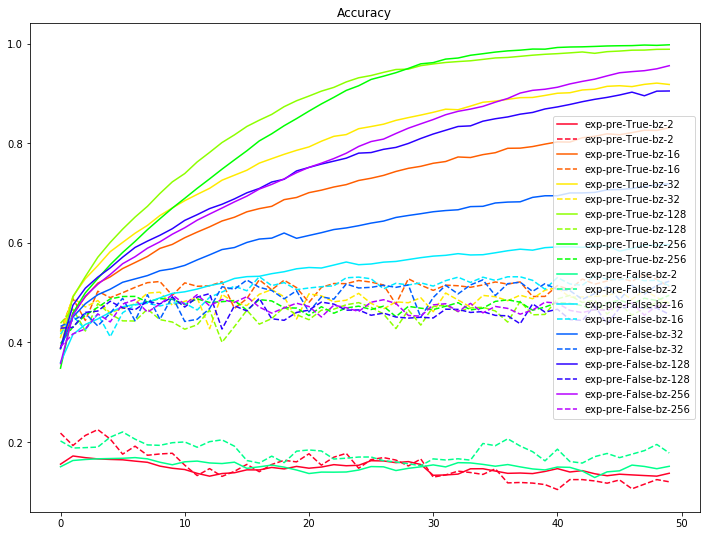

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]

plt.figure(figsize=(12,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(12,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()